# NBEATS

The Neural Basis Expansion Analysis (`NBEATS`) is an `MLP`-based deep neural architecture with backward and forward residual links. The network has two variants: (1) in its interpretable configuration, `NBEATS` sequentially projects the signal into polynomials and harmonic basis to learn trend and seasonality components; (2) in its generic configuration, it substitutes the polynomial and harmonic basis for identity basis and larger network's depth.

In the paper (N-HiTS: Neural Hierarchical Interpolation for Time Series Forecasting), the author implemented updated version of Nbeats model which can work on multivariate time-series data. But the original version of Nbeats can only work on univariate time-series only.

Here we use Airpassenger data set, which only contains one time-serie. We focus on the original version of model.

**References**<br>
-[Boris N. Oreshkin, Dmitri Carpov, Nicolas Chapados, Yoshua Bengio (2019). "N-BEATS: Neural basis expansion analysis for interpretable time series forecasting".](https://arxiv.org/abs/1905.10437)

The model does not contain any Recurrent or self-attention layers. Thus, faster training and stable gradient flow.

Figure 1 displays the top-level view of NBeats architacture.

Figure 1

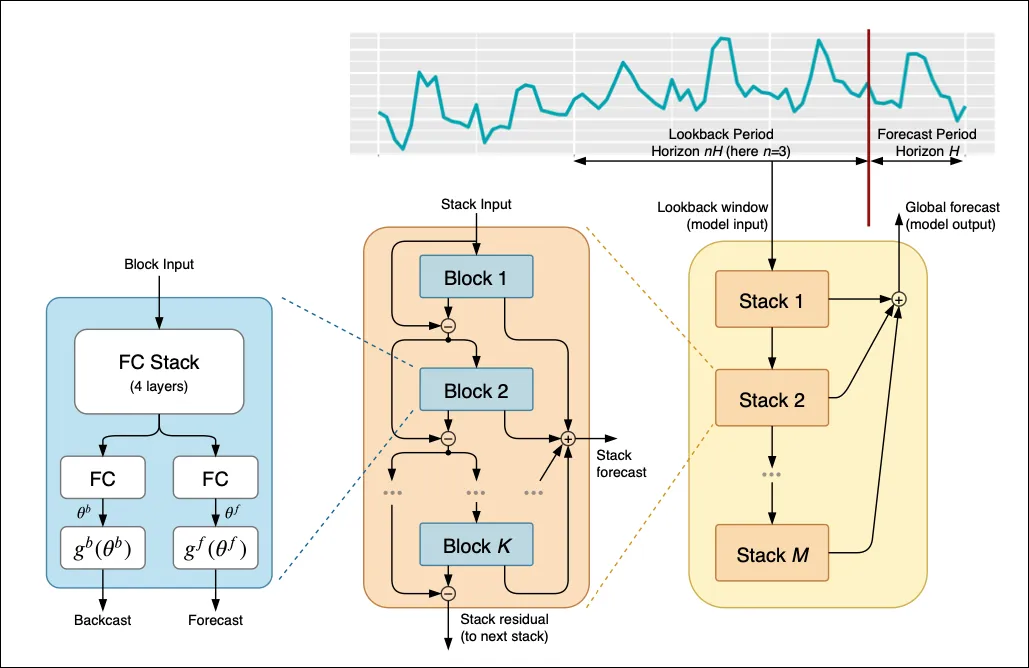

In [ ]:
from IPython.display import Image, display, Markdown

display(Markdown("Figure 1"))

display(Image(filename="NBeats.png", width=750))

#### The block (blue color) - the basic processing unit.
#### The stack (orange color) - a collection of blocks.
#### The final model (yellow color) - a collection of stacks.

#### Every neural network layer in the model is a fully-connected layer.

### Comparing Nbeats and Nhits
#### Similar


1.   The model makes both a forecast and backcast.
2.   It is made of stacks and blocks.
3.   The final prediction is the sum of the partial predictions of each stack.
4.   There are residual connections between each block in a stack.

#### Different

1.   Nhits consists an additional Maxpool layer in each block.
2.   Each stack has different kernel size. The length of kernel size determines the rate of sampling.

The reason that Nhits outperform than Nbeats lies on the differences. The Maxpool layer allows stacks focus on specifically long-term or short-term horizon of predicting. So it will perform better on the long-term prediction. Besides, the kernel size which has a larger length, will has less parameter, which will reduce the computational complexity.






### Dataset: Airpassenger

There are three datasets relating to airpassenger.
"Airpassenger" only contains the monthly totals of international passengers from 1949 to 1960.
"AirpassengerPanel" contains the

In [ ]:
!pip install pytorch-lightning

In [ ]:
!pip install neuralforecast

INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[]

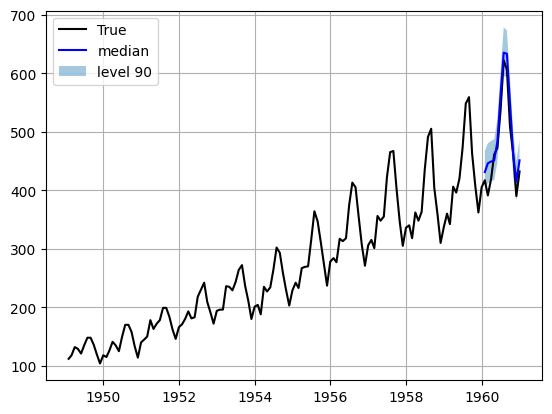

In [ ]:
#| eval: false
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

model = NBEATS(h=12, input_size=24,
               loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
               stack_types = ['identity', 'trend', 'seasonality'],
               max_steps=100,
               val_check_steps=10,
               early_stop_patience_steps=2)

fcst = NeuralForecast(
    models=[model],
    freq='M'
)
fcst.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
forecasts = fcst.predict(futr_df=Y_test_df)

# Plot quantile predictions
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['NBEATS-median'], c='blue', label='median')
plt.fill_between(x=plot_df['ds'][-12:],
                 y1=plot_df['NBEATS-lo-90'][-12:].values,
                 y2=plot_df['NBEATS-hi-90'][-12:].values,
                 alpha=0.4, label='level 90')
plt.grid()
plt.legend()
plt.plot()

In [ ]:
AirPassengers
count=len(AirPassengers)
print(count)

144


In [ ]:
AirPassengersPanel

,unique_id,ds,y,trend,y_[lag12]
0,Airline1,1949-01-31,112.0,0,112.0
1,Airline1,1949-02-28,118.0,1,118.0
2,Airline1,1949-03-31,132.0,2,132.0
3,Airline1,1949-04-30,129.0,3,129.0
4,Airline1,1949-05-31,121.0,4,121.0
...,...,...,...,...,...
283,Airline2,1960-08-31,906.0,283,859.0
284,Airline2,1960-09-30,808.0,284,763.0
285,Airline2,1960-10-31,761.0,285,707.0
286,Airline2,1960-11-30,690.0,286,662.0


In [ ]:
AirPassengersStatic

,unique_id,airline1,airline2
0,Airline1,0,1
1,Airline2,1,0


In [ ]:
y_true = Y_test_df.y.values
y_hat = Y_hat_df['NBEATS'].values


In [ ]:
from neuralforecast.losses.numpy import mae, mse

print('MAE: ', mae(y_hat, y_true))
print('MSE: ', mse(y_hat, y_true))

MAE:  25.414713541666668
MSE:  870.3795575544549
